In [1]:
#!pip install scikeras keras-tuner -q

In [95]:
import keras
import tensorflow as tf
from scikeras.wrappers import KerasRegressor
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from scipy.stats import reciprocal
from sklearn.model_selection import RandomizedSearchCV
from pathlib import Path
import keras_tuner as kt
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

In [3]:
housing = fetch_california_housing()

x_train_full, x_test, y_train_full, y_test = train_test_split(housing.data, housing.target, random_state=42)
x_train, x_valid, y_train, y_valid = train_test_split(x_train_full, y_train_full, random_state=42)

In [4]:
# scaling
std_scaler = StandardScaler()
x_train = std_scaler.fit_transform(x_train)
x_valid = std_scaler.transform(x_valid)
x_test = std_scaler.transform(x_test)

In [5]:
x_train.shape, y_train.shape

((11610, 8), (11610,))

### modelling

In [6]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="relu", input_shape=x_train.shape[1:]),
    keras.layers.Dense(1)
])

/Users/rishinigam/miniconda3/envs/py_3125/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [7]:
model.compile(loss="mean_squared_error", optimizer=keras.optimizers.SGD(learning_rate=0.001))
history = model.fit(x_train, y_train, epochs=40, validation_data=(x_valid, y_valid))
mse_test = model.evaluate(x_test, y_test)
x_new = x_test[:3]
y_pred = model.predict(x_new)

Epoch 1/40
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 518us/step - loss: 4.3507 - val_loss: 0.9726
Epoch 2/40
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 347us/step - loss: 0.8703 - val_loss: 0.7291
Epoch 3/40
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 347us/step - loss: 0.7132 - val_loss: 0.8071
Epoch 4/40
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 347us/step - loss: 0.6510 - val_loss: 0.5806
Epoch 5/40
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 349us/step - loss: 0.6219 - val_loss: 0.5373
Epoch 6/40
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 340us/step - loss: 0.5673 - val_loss: 0.5363
Epoch 7/40
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 342us/step - loss: 0.5392 - val_loss: 0.4916
Epoch 8/40
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 351us/step - loss: 0.5415 - val_loss: 0.5755
Epoch 9/40
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 360us/step - loss: 0.5083 - val_loss: 0.4668
Epoch 10/40
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 363us/step - loss: 0.4974 - val_loss: 0.5269
Epoch 11/40
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 359us/step - loss: 0.4875 - val_loss: 0.4639
Epoch 12/40
363/363 ━━━━━━━━━━

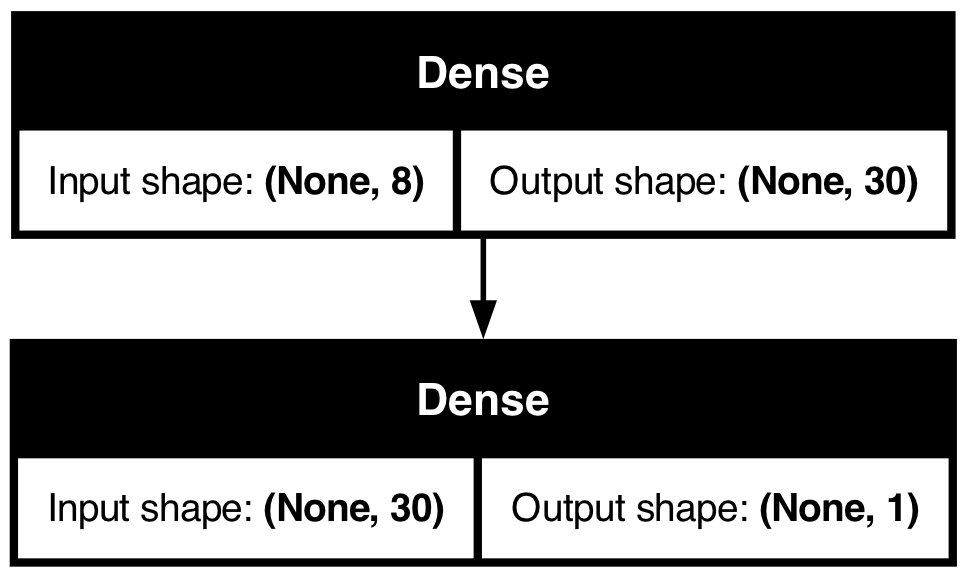

In [8]:
keras.utils.plot_model(model, "regression_model_california_sequential.png", show_shapes=True)

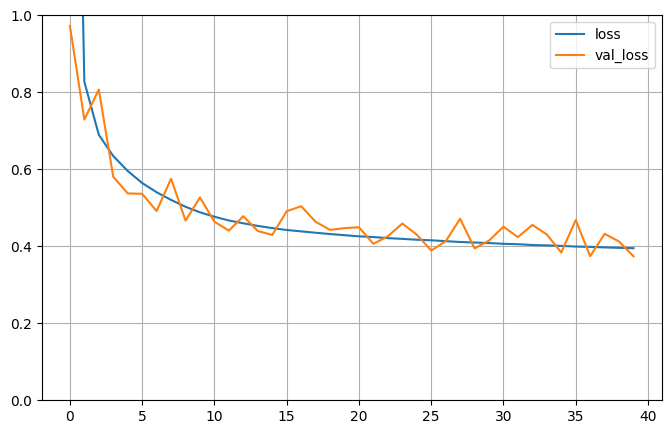

In [9]:
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.show()

## Using functional API

### Wide part getting input directly concatenated with hidden 2 layer

In [10]:
input_ = keras.layers.Input(shape=x_train.shape[1:])
hidden1 = keras.layers.Dense(30, activation="relu")(input_)
hidden2 = keras.layers.Dense(30, activation="relu")(hidden1)
concat = keras.layers.Concatenate()([input_, hidden2])
output = keras.layers.Dense(1)(concat)
model = keras.Model(inputs=[input_], outputs=[output])

In [11]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 8)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 30)        │        270 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 30)        │        930 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 38)        │          0 │ input_layer_1[0]… │
│ (Concatenate)       │                   │            │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 1)         │         39 │ concatenate[0][0] │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,239 (4.84 KB)

 Trainable params: 1,239 (4.84 KB)

 Non-trainable params: 0 (0.00 B)

In [12]:
model.compile(loss="mean_squared_error", optimizer=keras.optimizers.SGD(learning_rate=1e-3))
history = model.fit(x_train, y_train, epochs=20,
                    validation_data=(x_valid, y_valid))
mse_test = model.evaluate(x_test, y_test)
y_pred = model.predict(x_new)

Epoch 1/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 535us/step - loss: 3.2921 - val_loss: 1.0744
Epoch 2/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 420us/step - loss: 0.6995 - val_loss: 0.9927
Epoch 3/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 380us/step - loss: 0.6289 - val_loss: 0.6610
Epoch 4/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 371us/step - loss: 0.5576 - val_loss: 0.6705
Epoch 5/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 388us/step - loss: 0.5266 - val_loss: 0.5100
Epoch 6/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 395us/step - loss: 0.4882 - val_loss: 0.4820
Epoch 7/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 477us/step - loss: 0.4895 - val_loss: 0.4638
Epoch 8/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 380us/step - loss: 0.4603 - val_loss: 0.4426
Epoch 9/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 372us/step - loss: 0.4455 - val_loss: 0.4263
Epoch 10/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 369us/step - loss: 0.4622 - val_loss: 0.4155
Epoch 11/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 375us/step - loss: 0.4184 - val_loss: 0.4086
Epoch 12/20
363/363 ━━━━━━━━━━

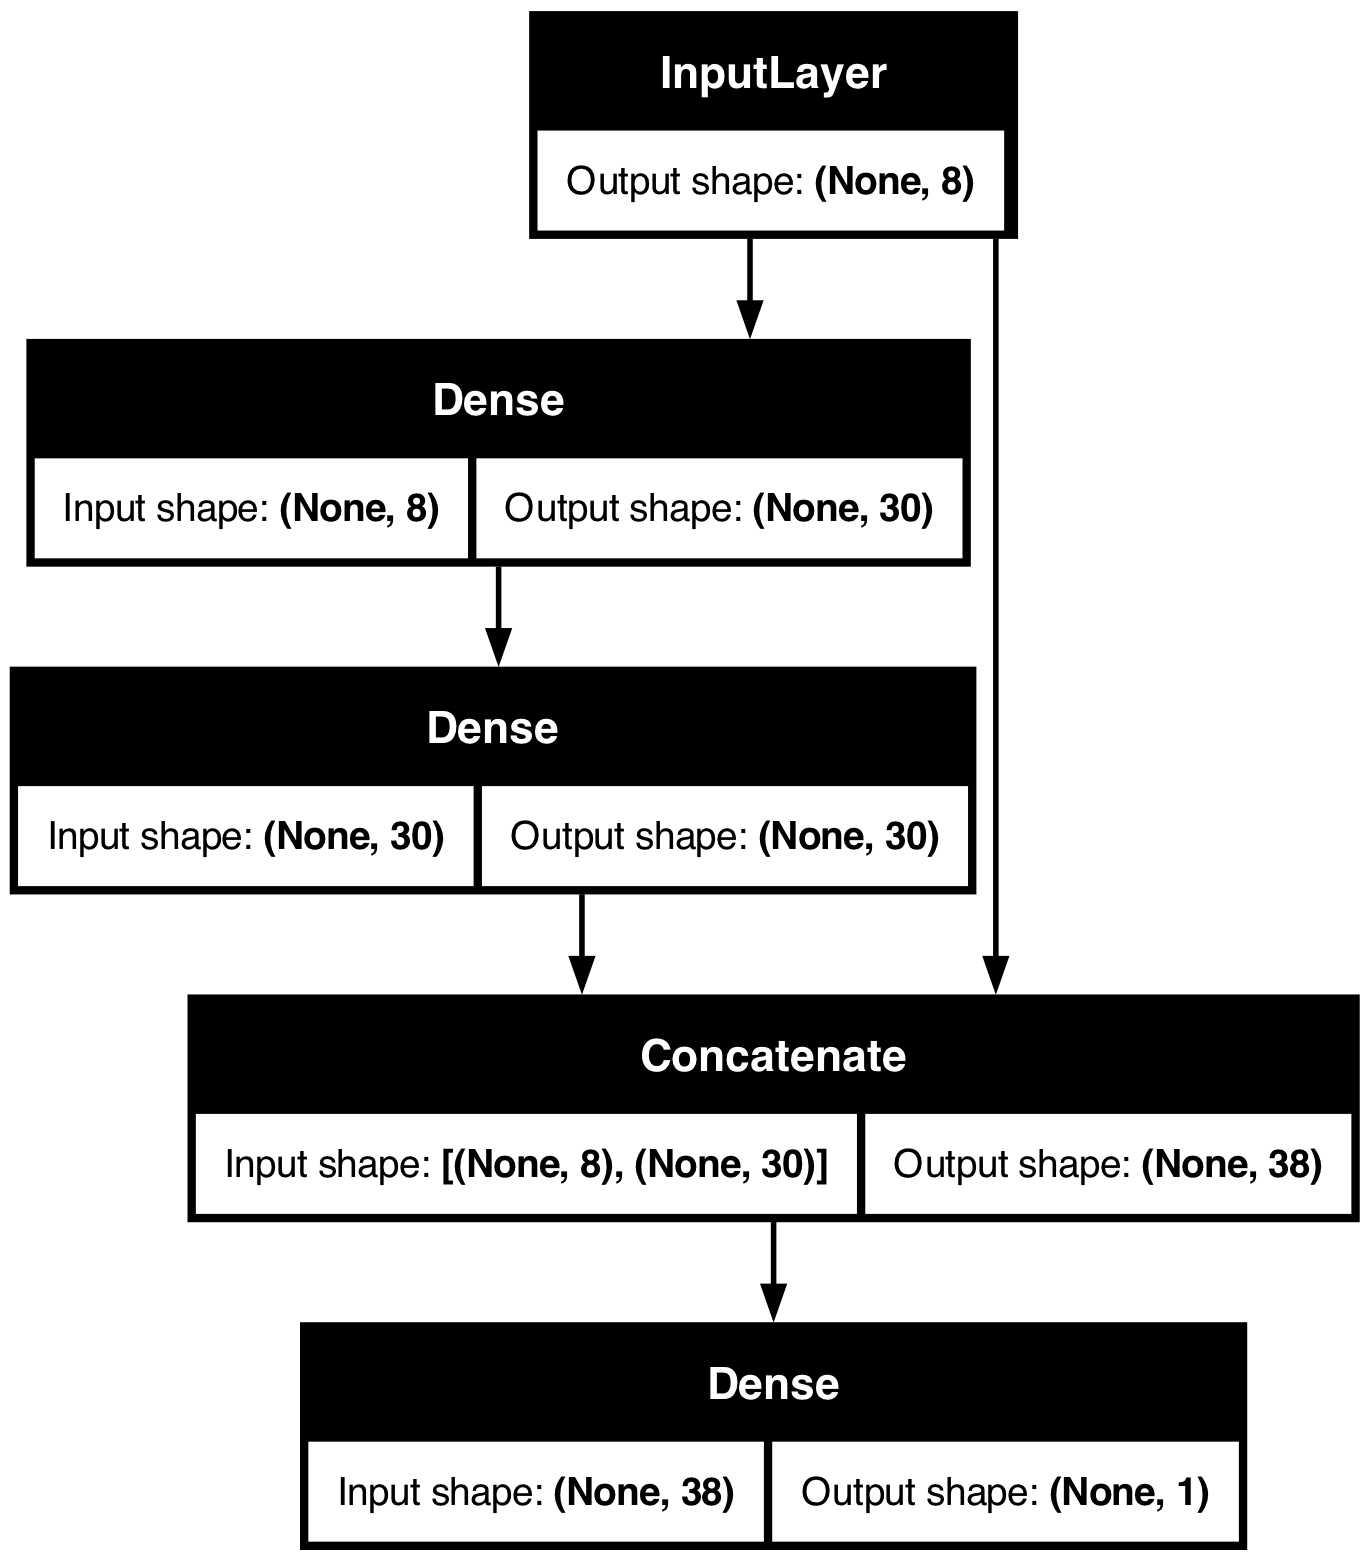

In [13]:
keras.utils.plot_model(model, "regression_model_california_wide_&_deep.png", show_shapes=True)

### Sending a subset of features throught the wide path and a different subset throught the deep path
- one solution to use multiple inputs

In [14]:
input_a = keras.layers.Input(shape=[5], name="wide_input")
input_b = keras.layers.Input(shape=[6], name="deep_input")
hidden1 = keras.layers.Dense(30, activation="relu")(input_b)
hidden2 = keras.layers.Dense(30, activation="relu")(hidden1)
concat = keras.layers.concatenate([input_a, hidden2])
output = keras.layers.Dense(1, name="output")(concat)
model = keras.Model(inputs=[input_a, input_b], outputs=[output])

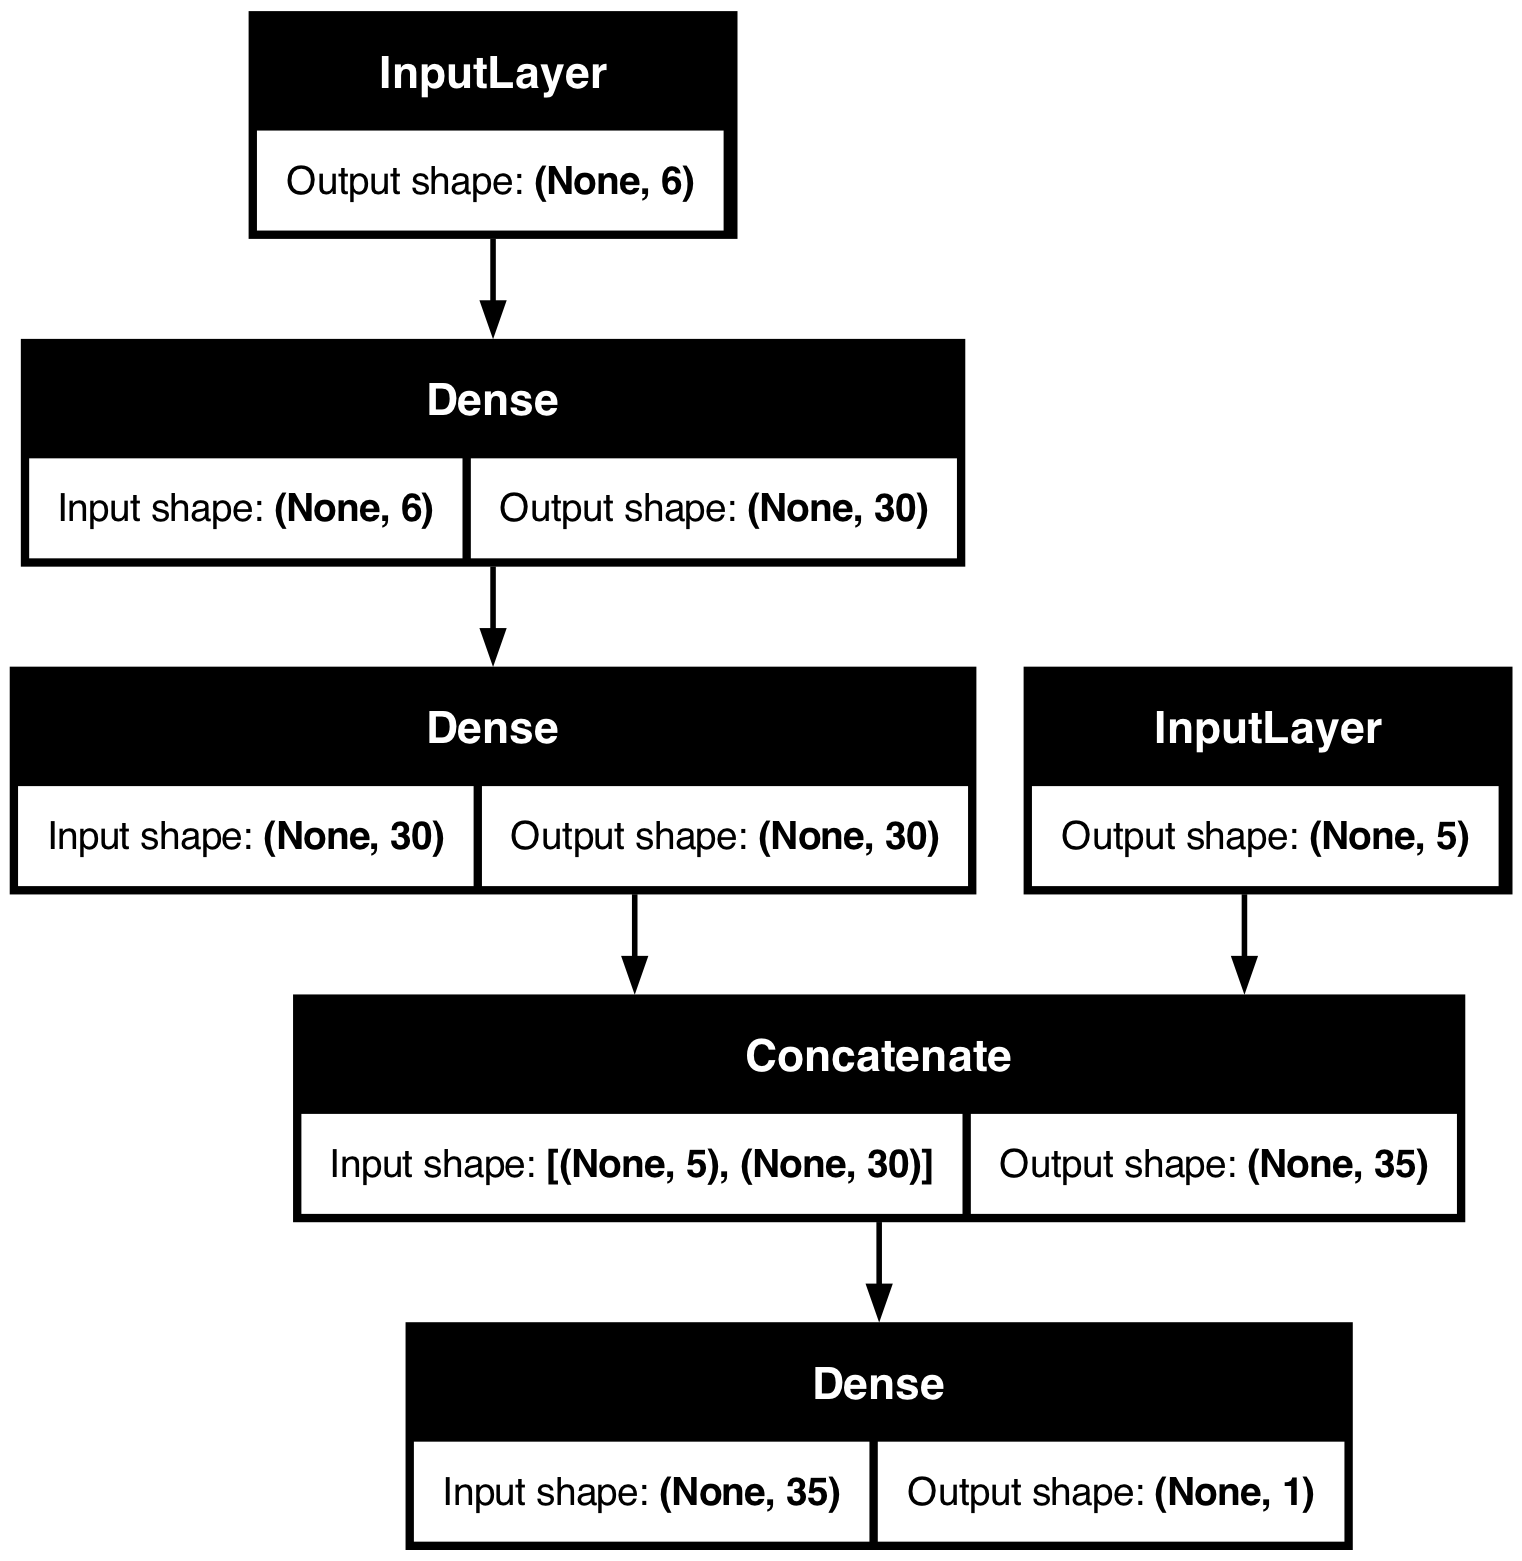

In [15]:
keras.utils.plot_model(model, "regression_model_california_subsetting_features.png", show_shapes=True)

In [16]:
model.compile(loss="mse", optimizer=keras.optimizers.SGD(learning_rate=0.001))

x_train_A, x_train_B = x_train[:, :5], x_train[:, 2:]
x_valid_A, x_valid_B = x_valid[:, :5], x_valid[:, 2:]
x_test_A, x_test_B = x_test[:, :5], x_test[:, 2:]
x_new_A, x_new_B = x_test_A[:3], x_test_B[:3]

history = model.fit((x_train_A, x_train_B), y_train, epochs=20,
                    validation_data=((x_valid_A, x_valid_B), y_valid))
mse_test = model.evaluate((x_test_A, x_test_B), y_test)
y_pred = model.predict((x_new_A, x_new_B))

Epoch 1/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 536us/step - loss: 3.3562 - val_loss: 4.0977
Epoch 2/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 376us/step - loss: 0.8652 - val_loss: 0.7124
Epoch 3/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 373us/step - loss: 0.6751 - val_loss: 0.6102
Epoch 4/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 377us/step - loss: 0.5935 - val_loss: 0.5397
Epoch 5/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 380us/step - loss: 0.5649 - val_loss: 0.5158
Epoch 6/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 381us/step - loss: 0.5206 - val_loss: 0.4781
Epoch 7/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 374us/step - loss: 0.4928 - val_loss: 0.4669
Epoch 8/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 372us/step - loss: 0.4804 - val_loss: 0.4504
Epoch 9/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 373us/step - loss: 0.4627 - val_loss: 0.4504
Epoch 10/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 461us/step - loss: 0.4524 - val_loss: 0.4306
Epoch 11/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 377us/step - loss: 0.4658 - val_loss: 0.4231
Epoch 12/20
363/363 ━━━━━━━━━━

### Another way is passing an auxilary output for _regularization_
- Could be used for handling multiple outputs

In [17]:
np.random.seed(42)
tf.random.set_seed(42)

In [18]:
input_a = keras.layers.Input(shape=[5], name="wide_input")
input_b = keras.layers.Input(shape=[6], name="deep_input")
hidden1 = keras.layers.Dense(30, activation="relu")(input_b)
hidden2 = keras.layers.Dense(30, activation="relu")(hidden1)
concat = keras.layers.concatenate([input_a, hidden2])
output = keras.layers.Dense(1, name="main_output")(concat)
aux_output = keras.layers.Dense(1, name="aux_output")(hidden2)
model = keras.models.Model(inputs=[input_a, input_b], outputs=[output, aux_output])

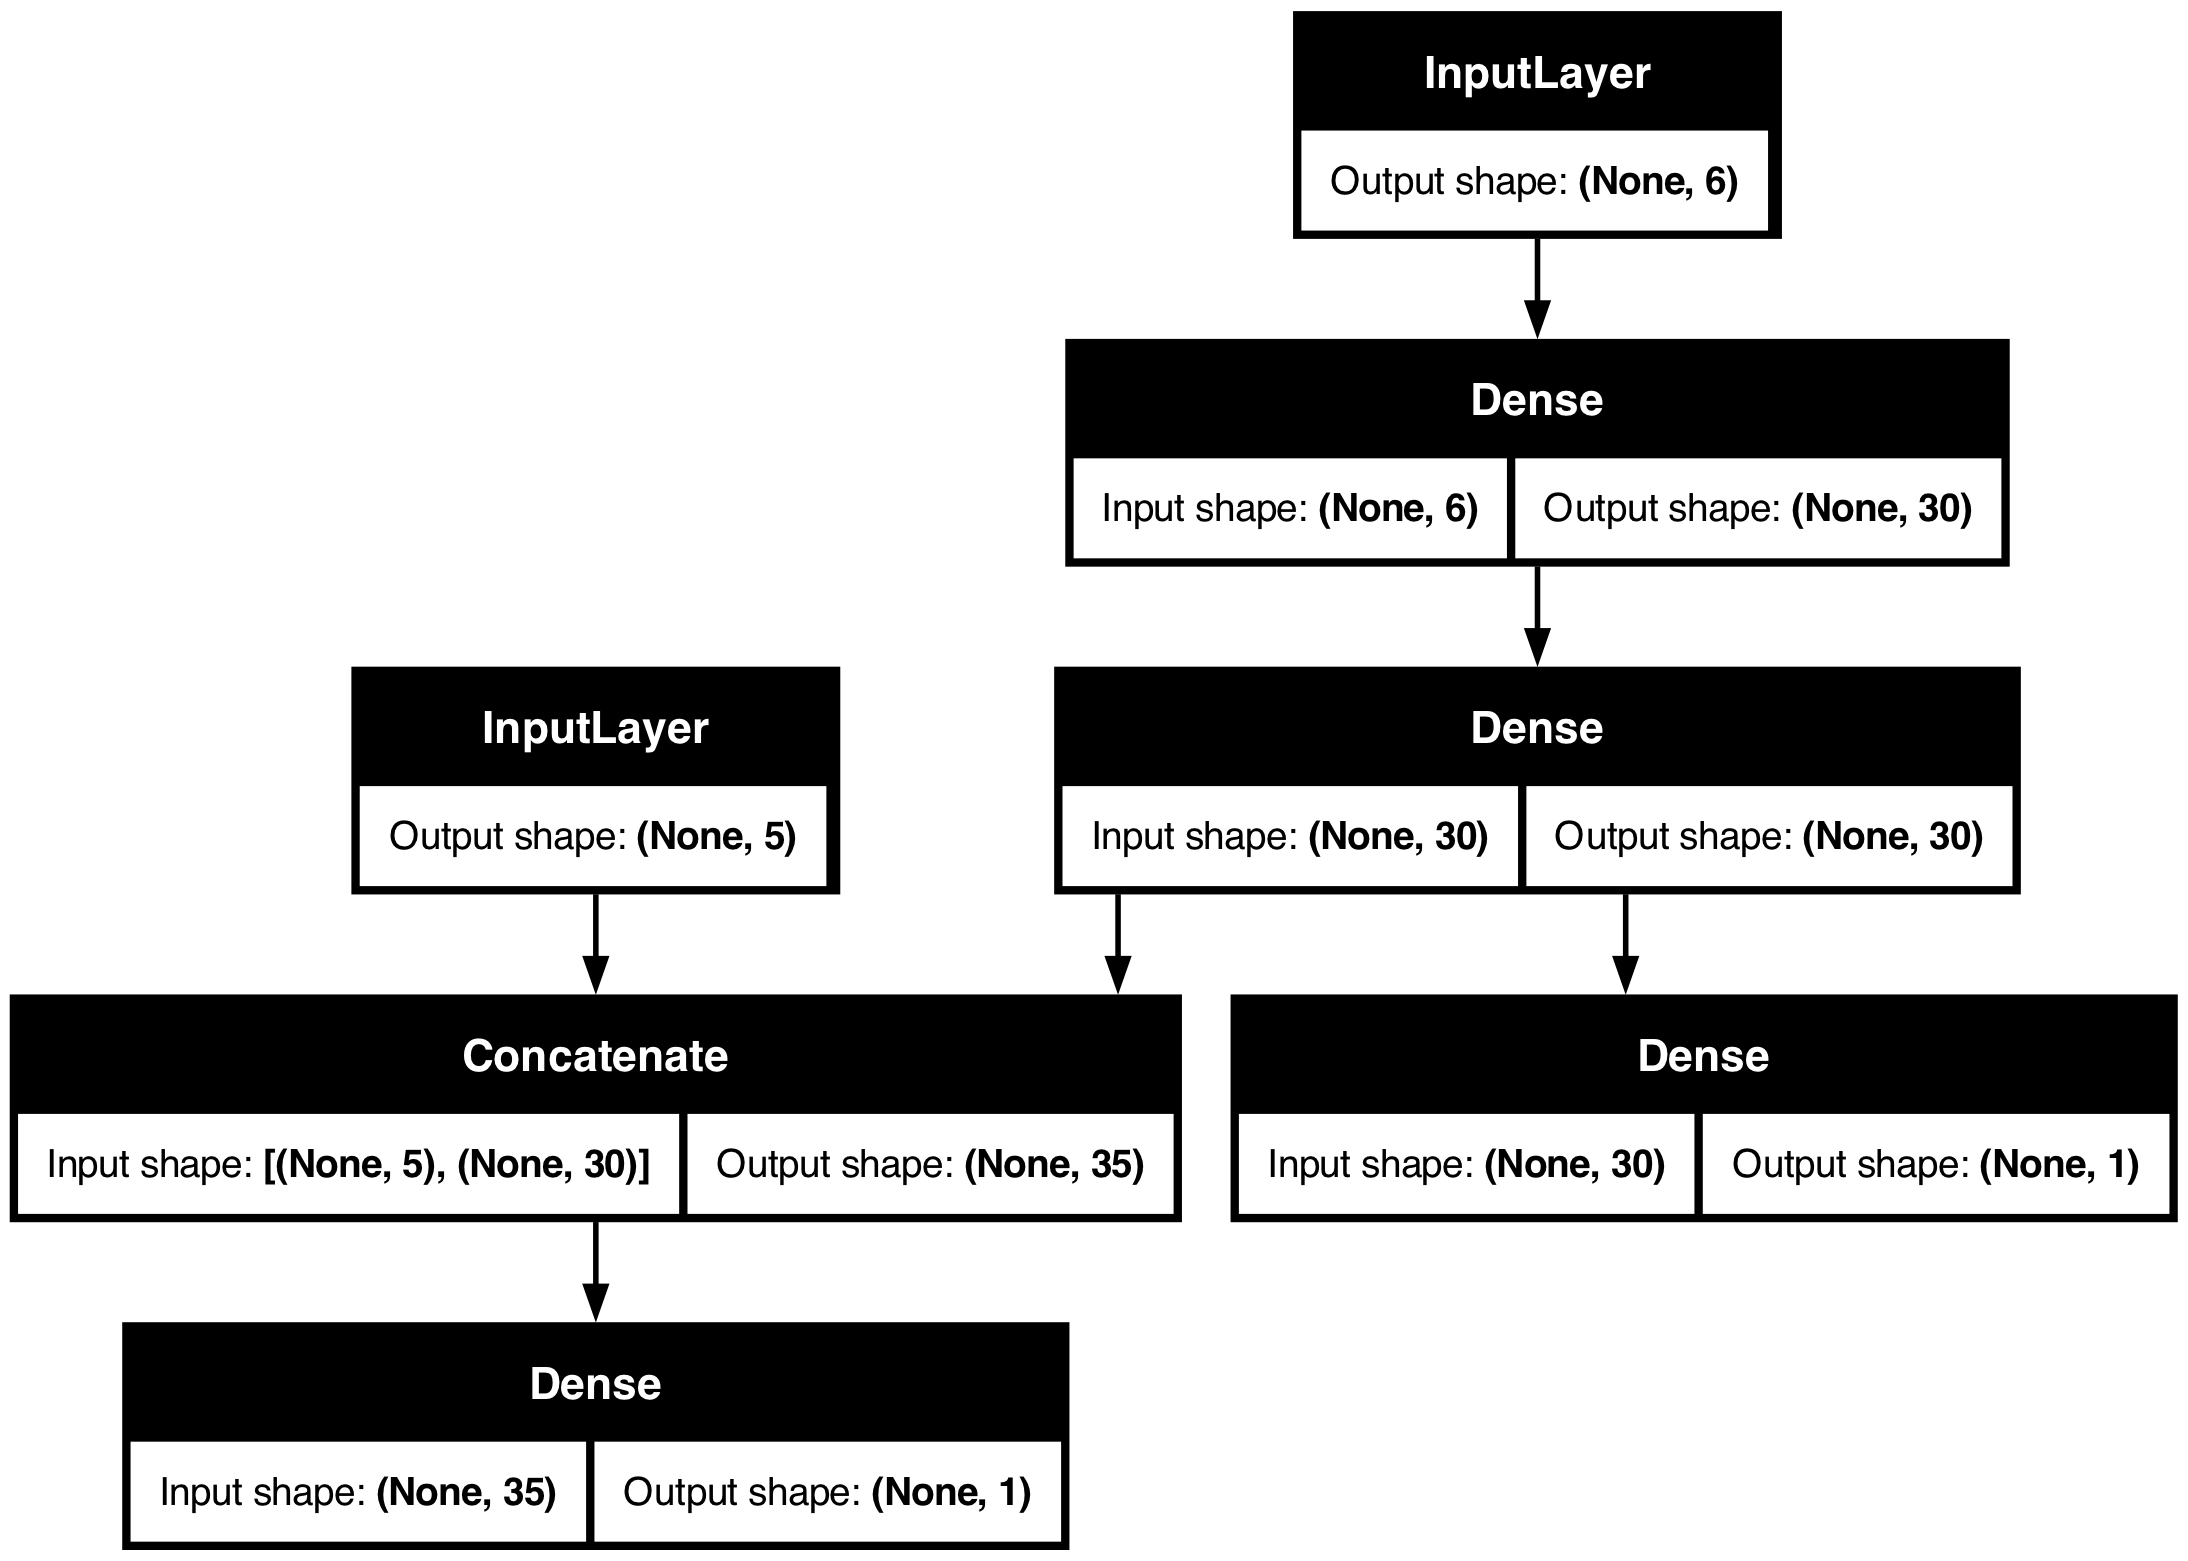

In [19]:
keras.utils.plot_model(model, "regression_model_california_subsetting_features_aux_output.png", show_shapes=True)

### Other info to keep in mind
- loss given during model.compile can be list of loss functions
- During training procide labels for each output, here both main output and aux output should predict the same thing

In [20]:
model.compile(loss=["mse", "mse"], loss_weights=[0.9, 0.1], optimizer=keras.optimizers.Adam(learning_rate=0.001, clipnorm=1.))

In [21]:
history = model.fit(
    [x_train_A, x_train_B], [y_train, y_train], epochs=20,
    validation_data=([x_valid_A, x_valid_B], [y_valid, y_valid])
)

Epoch 1/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 776us/step - aux_output_loss: 0.3560 - loss: 2.8815 - main_output_loss: 2.5255 - val_aux_output_loss: 0.4256 - val_loss: 2.9990 - val_main_output_loss: 2.5720
Epoch 2/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 538us/step - aux_output_loss: 0.0695 - loss: 0.6028 - main_output_loss: 0.5333 - val_aux_output_loss: 0.5204 - val_loss: 4.6428 - val_main_output_loss: 4.1201
Epoch 3/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 547us/step - aux_output_loss: 0.0574 - loss: 0.4693 - main_output_loss: 0.4119 - val_aux_output_loss: 0.4305 - val_loss: 2.3288 - val_main_output_loss: 1.8973
Epoch 4/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 543us/step - aux_output_loss: 0.0531 - loss: 0.4227 - main_output_loss: 0.3696 - val_aux_output_loss: 0.3372 - val_loss: 1.3594 - val_main_output_loss: 1.0216
Epoch 5/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 533us/step - aux_output_loss: 0.0499 - loss: 0.3975 - main_output_loss: 0.3477 - val_aux_output_loss: 0.2358 - val_loss: 0.7856 - val_main_output_los

In [22]:
total_loss, main_loss, aux_loss = model.evaluate([x_test_A, x_test_B], [y_test, y_test])
y_pred_main, y_pred_aux = model.predict([x_new_A, x_new_B])

162/162 ━━━━━━━━━━━━━━━━━━━━ 0s 286us/step - aux_output_loss: 0.0387 - loss: 0.3326 - main_output_loss: 0.2940
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


In [23]:
x_test_A.shape, x_test_B.shape, y_test.shape

((5160, 5), (5160, 6), (5160,))

### Using Subclassing API to build Dynamic Models

In [24]:
class WideAndDeepModel(keras.models.Model):
    def __init__(self, units=30, activation='relu', **kwargs):
        super().__init__(**kwargs)
        self.hidden1 = keras.layers.Dense(units, activation=activation)
        self.hidden2 = keras.layers.Dense(units, activation=activation)
        self.main_output = keras.layers.Dense(1)
        self.aux_output = keras.layers.Dense(1)

    def call(self, inputs):
        input_A, input_B = inputs
        hidden1 = self.hidden1(input_B)
        hidden2 = self.hidden2(hidden1)
        concat = keras.layers.concatenate([input_A, hidden2])
        main_output = self.main_output(concat)
        aux_output = self.aux_output(hidden2)
        return main_output, aux_output

model = WideAndDeepModel(30, activation='relu')

In [25]:
model.compile(loss='mse', loss_weights=[0.9, 0.1], optimizer=keras.optimizers.SGD(learning_rate=1e-3))
history = model.fit((x_train_A, x_train_B), (y_train, y_train), epochs=10, validation_data=((x_valid_A, x_valid_B),(y_valid, y_valid)))
total_loss, main_loss, aux_loss = model.evaluate((x_test_A, x_test_B), (y_test, y_test))
y_pred_main, y_pred_aux = model.predict((x_new_A, x_new_B))

Epoch 1/10
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 667us/step - loss: 3.8391 - mse_loss: 0.4903 - val_loss: 1.3344 - val_mse_loss: 0.4656
Epoch 2/10
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 444us/step - loss: 1.0475 - mse_loss: 0.2751 - val_loss: 1.1208 - val_mse_loss: 0.5038
Epoch 3/10
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 439us/step - loss: 0.8473 - mse_loss: 0.2063 - val_loss: 1.0496 - val_mse_loss: 0.4895
Epoch 4/10
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 436us/step - loss: 0.7636 - mse_loss: 0.1765 - val_loss: 0.9537 - val_mse_loss: 0.4256
Epoch 5/10
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.7152 - mse_loss: 0.1611 - val_loss: 0.8529 - val_mse_loss: 0.3499
Epoch 6/10
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 479us/step - loss: 0.6811 - mse_loss: 0.1515 - val_loss: 0.7653 - val_mse_loss: 0.2855
Epoch 7/10
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 479us/step - loss: 0.6540 - mse_loss: 0.1446 - val_loss: 0.7012 - val_mse_loss: 0.2405
Epoch 8/10
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 440us/step - loss: 0.6313 - mse_loss: 0.1391 - 

### Adding callbacks

- ModelCheckpoints
- EarlyStopping
- Custom callback (ratio of validation loss and training loss furing training) 

### Tensorboard

In [26]:
root_logdir = os.path.join(os.curdir, "my_logs")

In [27]:
def get_run_logdir():
    import time
    run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
    return os.path.join(root_logdir, run_id)

run_logdir = get_run_logdir()
run_logdir

'./my_logs/run_2024_09_03-16_12_31'

In [28]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="relu", input_shape=[8]),
    keras.layers.Dense(30, activation="relu"),
    keras.layers.Dense(1)
])    
model.compile(loss="mse", optimizer=keras.optimizers.SGD(learning_rate=1e-3))

/Users/rishinigam/miniconda3/envs/py_3125/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [29]:
checkpoint_cb = keras.callbacks.ModelCheckpoint("my_keras_model.keras", save_best_only=True)
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)
history = model.fit(x_train, y_train, epochs=50, validation_data=(x_valid, y_valid), callbacks=[checkpoint_cb, tensorboard_cb])

Epoch 1/50
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 633us/step - loss: 2.4624 - val_loss: 1.6704
Epoch 2/50
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 446us/step - loss: 0.8290 - val_loss: 0.7031
Epoch 3/50
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 446us/step - loss: 0.6827 - val_loss: 0.5718
Epoch 4/50
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 437us/step - loss: 0.6255 - val_loss: 0.5312
Epoch 5/50
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 436us/step - loss: 0.5866 - val_loss: 0.5015
Epoch 6/50
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 444us/step - loss: 0.5571 - val_loss: 0.4776
Epoch 7/50
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 436us/step - loss: 0.5343 - val_loss: 0.4600
Epoch 8/50
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 453us/step - loss: 0.5162 - val_loss: 0.4480
Epoch 9/50
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 495us/step - loss: 0.5017 - val_loss: 0.4410
Epoch 10/50
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 433us/step - loss: 0.4898 - val_loss: 0.4380
Epoch 11/50
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 434us/step - loss: 0.4800 - val_loss: 0.4378
Epoch 12/50
363/363 ━━━━━━━━━━

In [30]:
%load_ext tensorboard
%tensorboard --logdir=./my_logs --port=6006

Reusing TensorBoard on port 6006 (pid 28996), started 22:19:32 ago. (Use '!kill 28996' to kill it.)

### Hyperparameter Tuning

In [68]:
fashion_mnist = tf.keras.datasets.fashion_mnist.load_data()
(x_train_full, y_train_full), (x_test, y_test) = fashion_mnist
x_train, y_train = x_train_full[:-5000], y_train_full[:-5000]
x_valid, y_valid = x_train_full[-5000:], y_train_full[-5000:]

In [96]:
# you can also build model by
def build_model(hp):
    n_hidden = hp.Int("n_hidden", min_value=0, max_value=8, default=2)
    n_neurons = hp.Int("n_neurons", min_value=16, max_value=256)
    learning_rate = hp.Float("learning_rate", min_value=1e-4, max_value=1e-2, sampling='log')
    optimizer = hp.Choice("optimizer", values=['sgd', 'adam'])
    if optimizer == 'sgd':
        optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)
    else:
        optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Flatten())
    for layer in range(n_hidden):
        model.add(tf.keras.layers.Dense(n_neurons, activation='relu'))
    model.add(tf.keras.layers.Dense(10, activation='softmax'))
    model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

In [97]:
# adding parameters

rnd_search = kt.RandomSearch(build_model, objective="val_accuracy", max_trials=5, directory='my_fashion_mnist', project_name='my_rnd_search', overwrite=True, seed=42)

root_logdir_ = Path(rnd_search.project_dir) / "tensorboard"
tensorboard_cb = tf.keras.callbacks.TensorBoard(root_logdir_)
early_stopping_cb = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
rnd_search.search(x_train, y_train, epochs=10, validation_data=(x_valid, y_valid), callbacks=[early_stopping_cb, tensorboard_cb])

Trial 5 Complete [00h 00m 14s]
val_accuracy: 0.8356000185012817

Best val_accuracy So Far: 0.8592000007629395
Total elapsed time: 00h 01m 15s


In [ ]:
%tensorboard --logdir {root_logdir_}

In [91]:
top3_mdls = rnd_search.get_best_models(num_models=3)
best_mdl = top3_mdls[0]

In [92]:
top3_params = rnd_search.get_best_hyperparameters(num_trials=3)
top3_params[0].values

{'n_hidden': 7,
 'n_neurons': 100,
 'learning_rate': 0.0012482904754698163,
 'optimizer': 'sgd'}

In [93]:
best_trial = rnd_search.oracle.get_best_trials(num_trials=1)[0]
best_trial.summary()

Trial 1 summary
Hyperparameters:
n_hidden: 7
n_neurons: 100
learning_rate: 0.0012482904754698163
optimizer: sgd
Score: 0.8551999926567078


In [94]:
best_trial.metrics.get_last_value("val_accuracy")

0.8551999926567078

In [88]:
%reload_ext tensorboard
%load_ext tensorboard
%tensorboard --logdir ./my_fashion_mnist/

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard
